In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torchvision import datasets, transforms

# import local packages
from utils import data_utils, training_utils
from utils.training_utils import train_model, test_model
from models.dense_convtranspose1d import DenseConvTranspose1D

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Looping to generate data and training

In [3]:
def visualize_trained_net(dataloader_test, size_fig=(21,12)):
    for idx, data in enumerate(dataloader_test):
        if idx>=4:
            break
        X, y = data
        X = X.to(device)
        y = y.to(device)
        y_pred = net_dense(X)  # [N_eg,2,N_freq]

        y_np = y.cpu().detach().numpy()
        y_pred_np = y_pred.cpu().detach().numpy()
        if idx==0:
            y_test_np = y_np
            y_test_pred_np = y_pred_np
        else:
            y_test_np = np.concatenate((y_test_np,y_np), axis=0)
            y_test_pred_np = np.concatenate((y_test_pred_np,y_pred_np), axis=0)
            
        if y_test_pred_np.shape[0]>=4:
            break
    print('y_test_np.shape:', y_test_np.shape)
    print('y_test_pred_np.shape:', y_test_pred_np.shape)

    fig1 = plt.figure(1, figsize=size_fig)
    fig1.suptitle('Training result on test set: freq-R')
    for idx_fig in range(4):
        plt.subplot(2, 2, idx_fig+1)
        plt.scatter(np.arange(y_test_np.shape[2]), y_test_np[idx_fig,0,:], c='r')
        plt.scatter(np.arange(y_test_pred_np.shape[2]), y_test_pred_np[idx_fig,0,:], c='b')
        plt.legend(('true', 'prediction'))
        plt.title('sample idx: '+str(idx_fig))

    fig2 = plt.figure(2, figsize=size_fig)
    fig2.suptitle('Training result on test set: freq-T')
    for idx_fig in range(4):
        plt.subplot(2, 2, idx_fig+1)
        plt.scatter(np.arange(y_test_np.shape[2]), y_test_np[idx_fig,1,:], c='r')
        plt.scatter(np.arange(y_test_pred_np.shape[2]), y_test_pred_np[idx_fig,1,:], c='b')
        plt.legend(('true', 'prediction'))
        plt.title('sample idx: '+str(idx_fig))
    plt.show()
    
    
def visualize_spectra_search(param_pick, R_pick, T_pick, size_fig=(21,12)):
    fig1 = plt.figure(1, figsize=size_fig)
    fig1.suptitle('Spectra search result: freq-R')
    for idx_fig in range(4):
        plt.subplot(2, 2, idx_fig+1)
        plt.scatter(np.arange(R_pick.shape[1]), R_pick[idx_fig,:], c='r')
        plt.title(str(idx_fig+1) + 'th best match')

    fig2 = plt.figure(2, figsize=size_fig)
    fig2.suptitle('Spectra search result:freq-T')
    for idx_fig in range(4):
        plt.subplot(2, 2, idx_fig+1)
        plt.scatter(np.arange(T_pick.shape[1]), T_pick[idx_fig,:], c='r')
        plt.title(str(idx_fig+1) + 'th best match')
    plt.show()

**************************** ROUND 1 ****************************
Freq truncate.
freq.shape: (222,)
N_possible: [100, 100] , 10000 in total
N_needed: 15
Sample points number available, continue calculating...
----------------
[ 1 / 15 ] [D1, D2] = [ 98. 146.]
Calculation Progress: 100%
----------------
[ 2 / 15 ] [D1, D2] = [ 99. 113.]
Calculation Progress: 100%
----------------
[ 3 / 15 ] [D1, D2] = [ 93. 126.]
Calculation Progress: 100%
----------------
[ 4 / 15 ] [D1, D2] = [ 65. 110.]
Calculation Progress: 100%
----------------
[ 5 / 15 ] [D1, D2] = [55. 73.]
Calculation Progress: 100%
----------------
[ 6 / 15 ] [D1, D2] = [68. 90.]
Calculation Progress: 100%
----------------
[ 7 / 15 ] [D1, D2] = [148. 147.]
Calculation Progress: 100%
----------------
[ 8 / 15 ] [D1, D2] = [121.  58.]
Calculation Progress: 100%
----------------
[ 9 / 15 ] [D1, D2] = [100. 144.]
Calculation Progress: 100%
----------------
[ 10 / 15 ] [D1, D2] = [124. 101.]
Calculation Progress: 100%
--------------

----------------------------------------------------------------------
*** EPOCH 46 || AVG LOSS 0.00028998108173254876
### TEST LOSS  0.00024671432765899226
----------------------------------------------------------------------
*** EPOCH 47 || AVG LOSS 0.0002925775115727447
### TEST LOSS  0.00021854710939805955
----------------------------------------------------------------------
*** EPOCH 48 || AVG LOSS 0.00025453480678455285
### TEST LOSS  0.00015406439100236943
----------------------------------------------------------------------
*** EPOCH 49 || AVG LOSS 0.00027952603219697875
### TEST LOSS  0.00010432169074192643
----------------------------------------------------------------------
*** EPOCH 50 || AVG LOSS 0.0002096303253589819
### TEST LOSS  0.00017818987059096494
----------------------------------------------------------------------
*** EPOCH 51 || AVG LOSS 0.00021332699931614723
### TEST LOSS  0.00012902678281534463
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 100 || AVG LOSS 0.00023397899312840308
### TEST LOSS  0.00013606568245450035
----------------------------------------------------------------------
*** EPOCH 101 || AVG LOSS 0.00019692829494791415
### TEST LOSS  0.00018178957301036766
----------------------------------------------------------------------
*** EPOCH 102 || AVG LOSS 0.00027756917503817625
### TEST LOSS  0.0005221176834311336
----------------------------------------------------------------------
*** EPOCH 103 || AVG LOSS 0.0002976674232437896
### TEST LOSS  0.00020606217246192196
----------------------------------------------------------------------
*** EPOCH 104 || AVG LOSS 0.000328926070505986
### TEST LOSS  0.00010338073722474898
----------------------------------------------------------------------
*** EPOCH 105 || AVG LOSS 0.00022048256141715683
### TEST LOSS  8.477521502451661e-05
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 154 || AVG LOSS 8.34386402554325e-06
### TEST LOSS  1.0870618401289297e-05
----------------------------------------------------------------------
*** EPOCH 155 || AVG LOSS 1.1333398458646115e-05
### TEST LOSS  8.845755170720318e-06
----------------------------------------------------------------------
*** EPOCH 156 || AVG LOSS 1.0524736277754224e-05
### TEST LOSS  2.787293063496084e-05
----------------------------------------------------------------------
*** EPOCH 157 || AVG LOSS 1.898399574808233e-05
### TEST LOSS  8.087591595540289e-06
----------------------------------------------------------------------
*** EPOCH 158 || AVG LOSS 1.0829138500412227e-05
### TEST LOSS  7.105900598010824e-06
----------------------------------------------------------------------
*** EPOCH 159 || AVG LOSS 8.209887149253821e-06
### TEST LOSS  8.254269535730904e-06
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 208 || AVG LOSS 4.69070115040419e-06
### TEST LOSS  4.135235712965368e-06
----------------------------------------------------------------------
*** EPOCH 209 || AVG LOSS 3.9967155089470905e-06
### TEST LOSS  3.2341123793836837e-06
----------------------------------------------------------------------
*** EPOCH 210 || AVG LOSS 3.5602858133643166e-06
### TEST LOSS  3.998145681786506e-06
----------------------------------------------------------------------
*** EPOCH 211 || AVG LOSS 4.4769316559722935e-06
### TEST LOSS  2.6062358908044794e-06
----------------------------------------------------------------------
*** EPOCH 212 || AVG LOSS 4.276393754783688e-06
### TEST LOSS  4.526752642656599e-06
----------------------------------------------------------------------
*** EPOCH 213 || AVG LOSS 3.479622159829887e-06
### TEST LOSS  5.216655381445889e-06
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 262 || AVG LOSS 4.169936676134966e-06
### TEST LOSS  2.352759774263783e-06
----------------------------------------------------------------------
*** EPOCH 263 || AVG LOSS 4.565594012243916e-06
### TEST LOSS  7.228819375389624e-06
----------------------------------------------------------------------
*** EPOCH 264 || AVG LOSS 5.682240968477951e-06
### TEST LOSS  3.5336018981979578e-06
----------------------------------------------------------------------
*** EPOCH 265 || AVG LOSS 3.6050649252198734e-06
### TEST LOSS  8.19400186931792e-06
----------------------------------------------------------------------
*** EPOCH 266 || AVG LOSS 8.609336418885505e-06
### TEST LOSS  5.333520827358977e-06
----------------------------------------------------------------------
*** EPOCH 267 || AVG LOSS 3.154713310019967e-06
### TEST LOSS  1.555750202442141e-06
---------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 316 || AVG LOSS 1.670395455827626e-05
### TEST LOSS  1.1147344290899733e-05
----------------------------------------------------------------------
*** EPOCH 317 || AVG LOSS 1.572645193543091e-05
### TEST LOSS  3.8962165263001225e-06
----------------------------------------------------------------------
*** EPOCH 318 || AVG LOSS 1.3386659922313508e-05
### TEST LOSS  1.2120240019915704e-05
----------------------------------------------------------------------
*** EPOCH 319 || AVG LOSS 1.3427345053666311e-05
### TEST LOSS  6.4999730208607316e-06
----------------------------------------------------------------------
*** EPOCH 320 || AVG LOSS 1.1590211571880598e-05
### TEST LOSS  4.345129658152776e-06
----------------------------------------------------------------------
*** EPOCH 321 || AVG LOSS 7.104822050981359e-06
### TEST LOSS  4.750721018353943e-06
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 370 || AVG LOSS 1.7279403607517452e-06
### TEST LOSS  1.042999542733014e-06
----------------------------------------------------------------------
*** EPOCH 371 || AVG LOSS 1.2545896206953936e-06
### TEST LOSS  4.201186887560955e-06
----------------------------------------------------------------------
*** EPOCH 372 || AVG LOSS 1.3418731886834698e-06
### TEST LOSS  9.46110143710636e-07
----------------------------------------------------------------------
*** EPOCH 373 || AVG LOSS 8.608994505721057e-07
### TEST LOSS  1.0666688012861414e-06
----------------------------------------------------------------------
*** EPOCH 374 || AVG LOSS 1.0394667915155272e-06
### TEST LOSS  5.054639302670694e-07
----------------------------------------------------------------------
*** EPOCH 375 || AVG LOSS 5.678077246310901e-07
### TEST LOSS  9.817275857434045e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 424 || AVG LOSS 1.1583514904600634e-06
### TEST LOSS  5.29909452022063e-07
----------------------------------------------------------------------
*** EPOCH 425 || AVG LOSS 8.215933396134763e-07
### TEST LOSS  8.818416480001664e-07
----------------------------------------------------------------------
*** EPOCH 426 || AVG LOSS 9.237175400282164e-07
### TEST LOSS  7.143766348841988e-07
----------------------------------------------------------------------
*** EPOCH 427 || AVG LOSS 8.122873187706621e-07
### TEST LOSS  7.26729676140773e-07
----------------------------------------------------------------------
*** EPOCH 428 || AVG LOSS 5.880171034533532e-07
### TEST LOSS  4.989362594187696e-07
----------------------------------------------------------------------
*** EPOCH 429 || AVG LOSS 5.22114639522897e-07
### TEST LOSS  4.502086738966682e-07
------------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 478 || AVG LOSS 6.105657355703897e-07
### TEST LOSS  9.887903994846663e-07
----------------------------------------------------------------------
*** EPOCH 479 || AVG LOSS 7.603555864932332e-07
### TEST LOSS  5.659392172674416e-07
----------------------------------------------------------------------
*** EPOCH 480 || AVG LOSS 8.205373736321538e-07
### TEST LOSS  1.147840919202281e-06
----------------------------------------------------------------------
*** EPOCH 481 || AVG LOSS 1.1128319044928502e-06
### TEST LOSS  1.7662051732258988e-06
----------------------------------------------------------------------
*** EPOCH 482 || AVG LOSS 9.194318778327215e-07
### TEST LOSS  1.4872358254554758e-06
----------------------------------------------------------------------
*** EPOCH 483 || AVG LOSS 7.607356219333876e-07
### TEST LOSS  5.533439567291983e-07
-------------------------------------------------------------

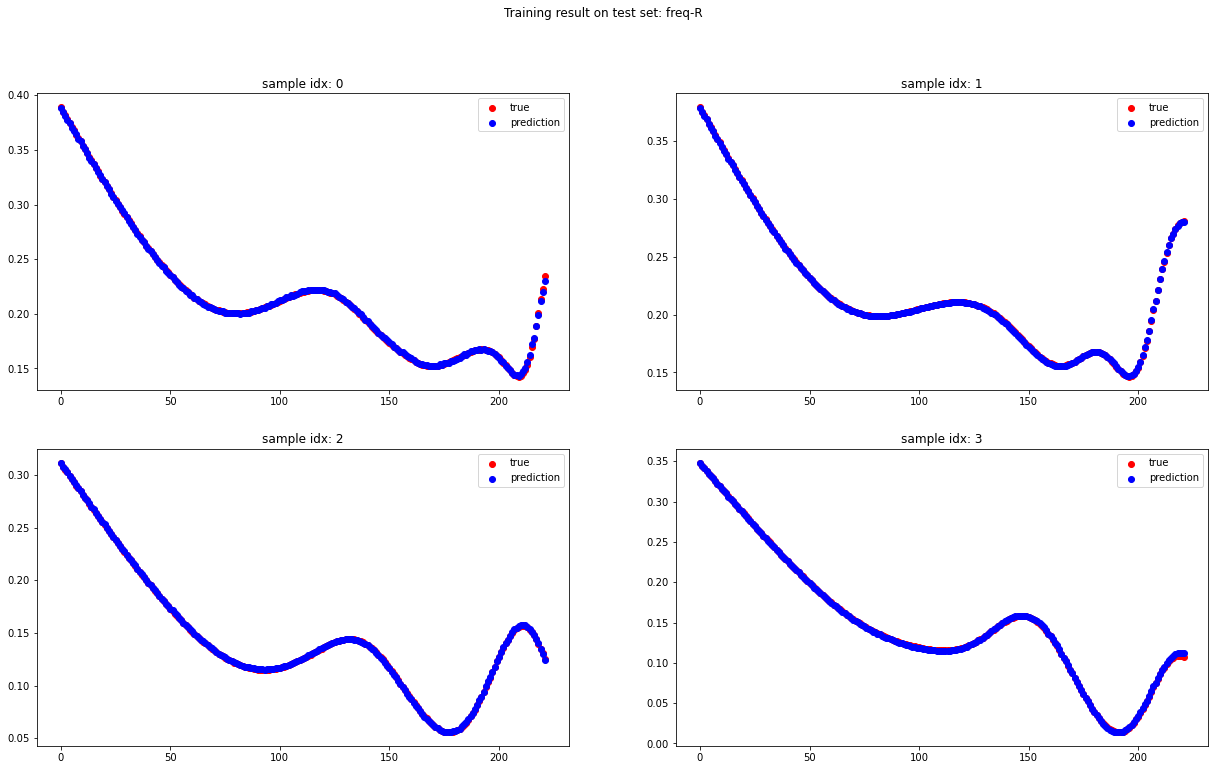

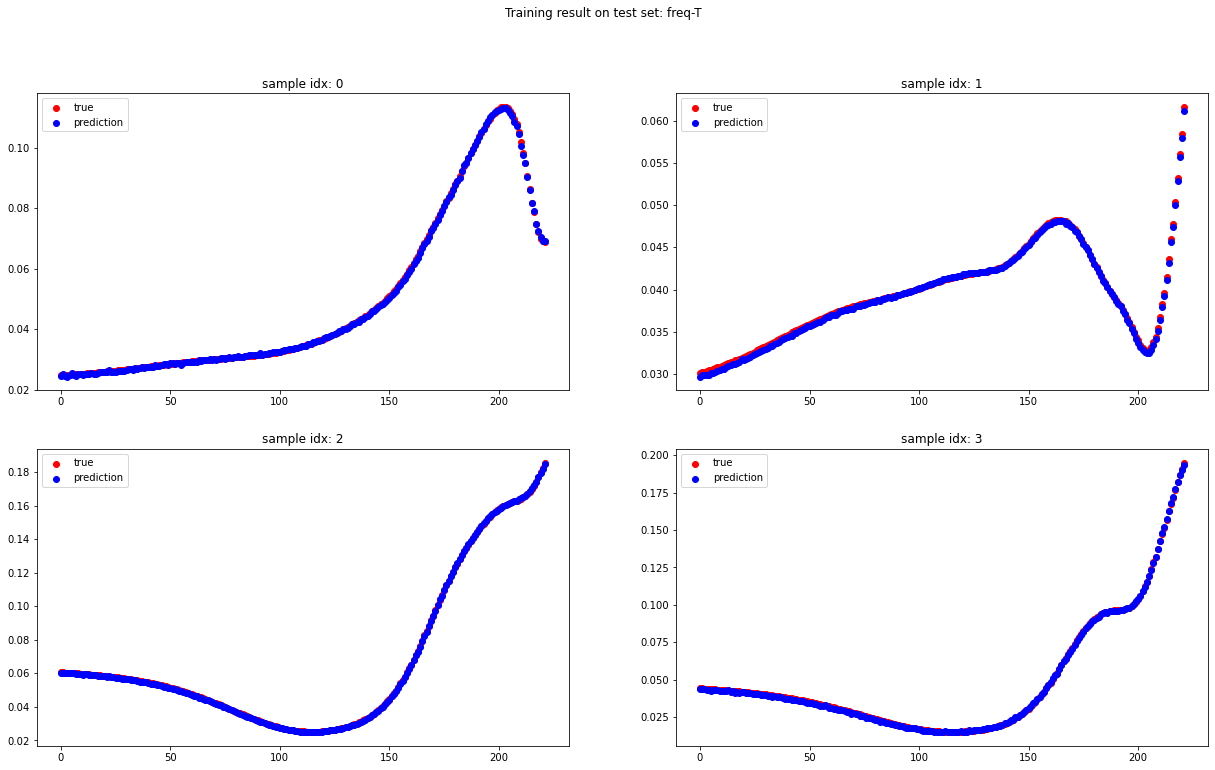

param_pick.shape: (10, 4)
param_pick: [[ 50.  50. 160.  75.]
 [ 50.  51. 160.  75.]
 [ 51.  50. 160.  75.]
 [ 50.  52. 160.  75.]
 [ 51.  51. 160.  75.]
 [ 52.  50. 160.  75.]
 [ 50.  53. 160.  75.]
 [ 51.  52. 160.  75.]
 [ 52.  51. 160.  75.]
 [ 53.  50. 160.  75.]]
R_pick.shape: (10, 222)
T_pick.shape: (10, 222)


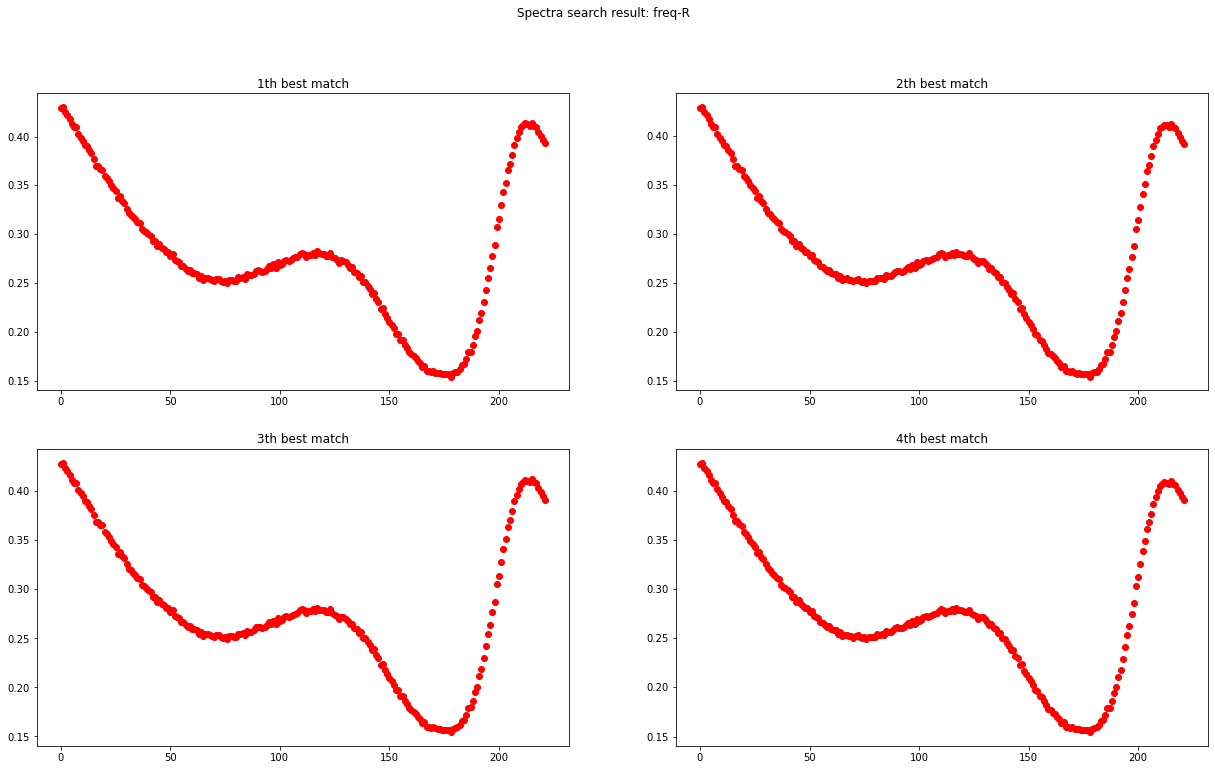

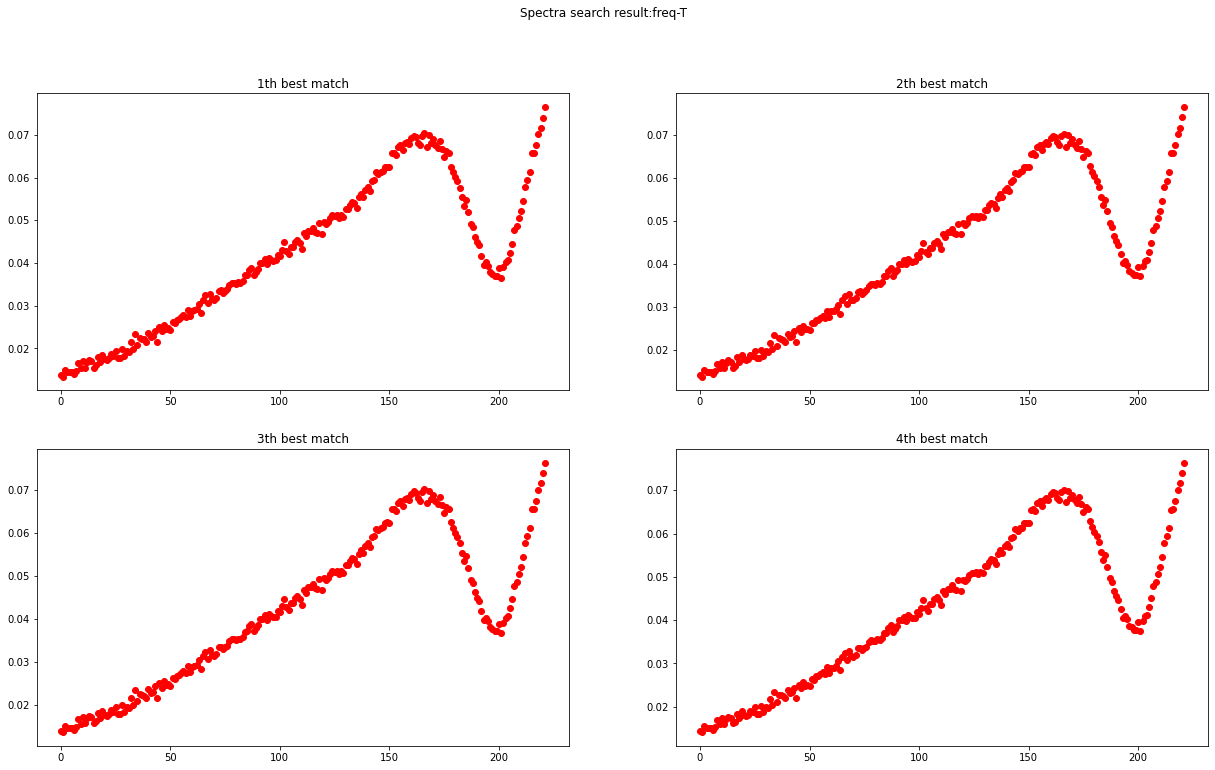

**************************** ROUND 2 ****************************
Freq truncate.
freq.shape: (222,)
N_possible: [100, 100] , 10000 in total
N_needed: 30
Sample points number available, continue calculating...
----------------
[ 1 / 15 ] [D1, D2] = [61. 64.]
Calculation Progress: 100%
----------------
[ 2 / 15 ] [D1, D2] = [123. 112.]
Calculation Progress: 8%

KeyboardInterrupt: 

In [4]:
loss_tolerance = 1e-3
loss = loss_tolerance+1  # start from a loss that bigger than tolerance
ROUND = 1  # round number for simulation and training


# ====== RCWA simulation prepare ======
# params range, [D1, D2]
params_range = [[50,150], [50,150]]
params_decimal = [0,0]
path_material_name = 'absorber'

# solver setting: [freq_step, freq_truncate, params_mesh, PQ_order, source, device]
'''
solver setting should not being changed while sampling and training!
'''
params_mesh = [512, 512]
order = 3  # RCWA accuracy, higher to be more accurate
PQ_order = [order, order]
ginc = [0, 0, 1]  # orig [0,0,1], incident source vector, unit vec
EP = [0, 1, 0]  # orig [0,1,0], incident source polarization, unit vec
source = [ginc, EP]
device_rcwa = 'gpu'
freq_step = 4  # freq step size, bigger to save more time, while less sampling freq points
freq_truncate = 1.7  # 'none' to no truncate
solver_setting = [freq_step, freq_truncate, params_mesh, PQ_order, source, device_rcwa]

# ====== Generate pseudo params, [D1, D2] ======
range_D1 = [50,150,1]  # [range_start, range_end, step_size]
range_D2 = [50,150,1]
list_range = [range_D1, range_D2]
pseudo_params_D1_D2 = data_utils.generate_pseudo_params(list_range)
# print(pseudo_params_D1_D2.shape)
# print(pseudo_params_D1_D2[-1])
a = 160.
t = 75.
param_other = np.array([a, t])
param_other = np.tile(param_other, (pseudo_params_D1_D2.shape[0], 1))
pseudo_params = np.concatenate((pseudo_params_D1_D2, param_other), axis=-1)  # [D1,D2,a,t]
# print(pseudo_params.shape)
# print(pseudo_params[0])

# ====== Define target spectra ======
tg_idx_freq_R = np.array([0,1])
tg_value_R = np.array([3,4])
tg_idx_freq_T = np.array([])
tg_value_T = np.array([])
target_data = [tg_idx_freq_R, tg_value_R, tg_idx_freq_T, tg_value_T]


plt.ion()  # interactive plt while looping
while loss>loss_tolerance:
    print('**************************** ROUND', ROUND, '****************************')
    # ====== Generate Simulation ======
    num_data = 15
    if ROUND==1:
        import_list = False
    else:
        import_list = True
    params_list, R, T = data_utils.generate_data_absorber(num_data, params_range, params_decimal, solver_setting_list=solver_setting,
                                           path_material_name=path_material_name, import_list=import_list, use_log=True)
#     print('params_list.shape:', params_list.shape)
#     print('R.shape:', R.shape)
#     print('T.shape:', T.shape)
    
    # save all data
    path_all_data_round = './data/' + path_material_name + '/all_data_' + path_material_name + '_ROUND_' + str(ROUND) + '.npz'
    np.savez(path_all_data_round, params_list=params_list, R=R, T=T)
    print('** Round data saved.')
    
    # generate all data stacked for all rounds
    if ROUND==1:
        params_list_all = params_list
        R_all = R
        T_all = T
    else:
        params_list_all = np.concatenate((params_list_all, params_list), axis=0)
        R_all = np.concatenate((R_all, R), axis=0)
        T_all = np.concatenate((T_all, T), axis=0)
    print('params_list_all.shape:', params_list_all.shape)
    print('R_all.shape:', R_all.shape)
    print('T_all.shape:', T_all.shape)
    path_all_data = './data/' + path_material_name + '/all_data_' + path_material_name + '.npz'
    np.savez(path_all_data, params_list=params_list_all, R=R_all, T=T_all)
    print('** All Rounds data saved.')
    
    
    # ====== Train Model with Simulation Data ======
    # prepare dataset
    dataset, dataloader = data_utils.generate_dataset_absorber(path_all_data, idx_pick_param=[], BTSZ=1)
    len_train = int((len(dataset)*0.7)//1)
    len_test = len(dataset)-len_train
    dataset_train, dataset_test = random_split(dataset, [len_train, len_test])
    print('LEN dataset_train:', len(dataset_train))
    print('LEN dataset_test:', len(dataset_test))
    BTSZ = 2
    dataloader_train = DataLoader(dataset_train, batch_size=BTSZ, shuffle=True)
    dataloader_test = DataLoader(dataset_test, batch_size=BTSZ, shuffle=True)
    print('LEN dataloader_train:', len(dataloader_train))
    print('LEN dataloader_test:', len(dataloader_test))
    
    # import network
    dim_in = params_list_all.shape[-1] + 2  # N_param
    dim_out = R_all.shape[-1]  # N_freq
    net_dense = DenseConvTranspose1D(dim_in,dim_out)
    net_dense = net_dense.to(device)
    
    # *** train network
    learning_rate = 1e-3
    optimizer = torch.optim.Adam(net_dense.parameters(), lr=learning_rate, weight_decay=0.0, amsgrad=True)
    criteon = nn.MSELoss()
    scheduler = None
    N_epoch = 500  # number of epochs trained
    loss_train, loss_test = training_utils.train_model(dataloader, dataloader_test, optimizer, criteon, net_dense, device, NUM_EPOCH=N_epoch, scheduler=scheduler)
    print('** loss_train', loss_train)
    print('** loss_test', loss_test)
    
    # visualize spectra on test set
    visualize_trained_net(dataloader_test)
    
    
    # ====== Spectra Search ======
    pseudo_params, spectra_R, spectra_T = data_utils.generate_pseudo_data(pseudo_params, net_dense, device, PATH_pseudo_dataset='', flag_save_pseudo_data=False)
    pseudo_data = [pseudo_params, spectra_R, spectra_T]
    param_pick, R_pick, T_pick, dist_pick = data_utils.spectra_search(pseudo_data, target_data, order=2, N_top=10)
    print('param_pick.shape:', param_pick.shape)
    print('param_pick:', param_pick)
    print('R_pick.shape:', R_pick.shape)
    print('T_pick.shape:', T_pick.shape)
    # visualize spectra search results
    visualize_spectra_search(param_pick, R_pick, T_pick)
    
    
    # ====== Run RCWA Search on Picked Params ======
    
    
    if ROUND>3:
        loss = 1e-7
    ROUND += 1
    
plt.ioff()

In [4]:
a = [1,9,2]
b = [2,5,1]
list = [a,b]

pseudo_params = data_utils.generate_pseudo_params(list)
print(pseudo_params)


range_D1 = [50,150,1]
range_D2 = [50,150,1]
list_range = [range_D1, range_D2]
pseudo_params_D1_D2 = data_utils.generate_pseudo_params(list_range)
print(pseudo_params_D1_D2.shape)
print(pseudo_params_D1_D2[-1])
a = 160.
t = 75.
param_other = np.array([a, t])
param_other = np.tile(param_other, (pseudo_params_D1_D2.shape[0], 1))
pseudo_params = np.concatenate((pseudo_params_D1_D2, param_other), axis=-1)
print(pseudo_params.shape)
print(pseudo_params[0])

[[1 2]
 [1 3]
 [1 4]
 [3 2]
 [3 3]
 [3 4]
 [5 2]
 [5 3]
 [5 4]
 [7 2]
 [7 3]
 [7 4]]
(10000, 2)
[149 149]
(10000, 4)
[ 50.  50. 160.  75.]


In [8]:
params_pseudo = np.array([[0.1,0.2,0.5],
                          [0.6,0.7,0.9],
                          [0.8,0.8,0.8]])

spectraR_pseudo = np.array([[3,4,6,7],
                            [7,8,2,1],
                            [3,5,2,1]])

spectraT_pseudo = np.array([[9,4,6,9],
                            [9,8,2,9],
                            [9,3,2,9]])

tg_idx_freq_R = np.array([0,1])
tg_value_R = np.array([3,4])
tg_idx_freq_T = np.array([])
tg_value_T = np.array([])

pseudo_data = [params_pseudo, spectraR_pseudo, spectraT_pseudo]
target_data = [tg_idx_freq_R, tg_value_R, tg_idx_freq_T, tg_value_T]
# if tg_idx_freq_R.size !=0 and tg_idx_freq_T.size==0:
#     print('search R')



param_pick, R_pick, T_pick, dist_pick = data_utils.spectra_search(pseudo_data, target_data, order=2, N_top=5)
print(param_pick)

[[0.1 0.2 0.5]
 [0.8 0.8 0.8]
 [0.6 0.7 0.9]]
